# Lab 3

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

## Imports

In [1]:
from typing import Any

import torch
from torch.autograd import Function
from torch import Tensor

import matplotlib.pyplot as plt
from  matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

Welcome to the third lab. The first exercise is an implementation of gradient descent
on a bivariate function. The second exercise is about computing derivatives of the
weights of a neural network, and the third exercise combines the previous two.

## Exercise 1
This exercise is about gradient descent. We will use the function
$f(x_1, x_2)=(x_1-6)^2+x_2^2-x_1x_2$ as a running example:

 1. Use pen and paper to do three iterations of gradient descent:
     - Find the gradient of $f$;
     - Start from the point $x_1=x_2=6$ and use a step size of $1/2$ for the first step,
    $1/3$ for the second step and $1/4$ for the third step;
     - What will happen if you keep going?
 2. Write a function that performs gradient descent:
     - For simplicity, we use a constant learning rate.
     - Can you find a way to prematurely stop the optimization when you are close to the
    optimum?

In [2]:
# Note: Defining a custom autograd function is not a necessity for this small task,
# but it is a good place to showcase some capabilities of PyTorch.

class MyFunction(Function):
    @staticmethod
    def forward(ctx: Any, x: Tensor) -> Tensor:
        # The "ctx" object serves to stash information for the backward pass
        ctx.save_for_backward(x)
        func_value = (
# TODO compute the value of f at x.
        (x[0] - 6)**2 + x[1]**2 - x[0]*x[1]
        )
        return func_value

    @staticmethod
    def backward(ctx: Any, grad_output: Tensor):
        # The "grad_output" parameter is the backpropagated gradient from subsequent
        # operations w.r.t. to the output of this function.
        x = ctx.saved_tensors[0]

        grad_x = torch.tensor([
# TODO compute the gradient of f at x.
        2*(x[0] - 6) - x[1],
        2*x[1] - x[0]
        ])
        return grad_output * grad_x

In [4]:

func = MyFunction()
# The "required_grad" argument needs to be True.
# Otherwise no gradients will be computed.
x = torch.tensor([6., 6.], requires_grad=True)

# Custom functions are applied over the "apply" method.
y = func.apply(x) 
print('Function output: {}'.format(y))

# Gradients for every operation in this chain are computed
# by calling the "backward" method on the output tensor.
y.backward()

# The x tensor now has a grad attribute with the gradients.
print('Gradients: {}'.format(x.grad))

# Note: No usage of auto differentiation was done in this example.

C:\Users\esual\AppData\Local\Temp\ipykernel_1912\2158443098.py:1: DeprecationWarning: <class '__main__.MyFunction'> should not be instantiated. Methods on autograd functionsare all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  func = MyFunction()


Function output: 0.0
Gradients: tensor([-6.,  6.])


Does it match what you computed?

In the next step we define a small gradient descent optimizer.

In [5]:
torch.tensor([float('inf')])

tensor([inf])

In [6]:

class GradientDescentOptimizer:
    def __init__(self,
                 func: Function,
                 max_steps: int,
                 alpha: float):
        """
        Init an Optimizer for performing GD.

        :param func: Function to apply.
        :param max_steps: Maximum number of GD steps.
        :param alpha: Learning Rate.
        """
        self.func = func
        self.max_steps = max_steps
        self.alpha = alpha

    def __call__(self, x: Tensor) -> Tensor:
        """
        Apply GD on a tensor.

        :param x: Input tensor.
        """
        # Usually you would apply the gradients inplace on the input tensor,
        # but for the sake of the example we keep the input tensor consistent and
        # work on a copy.
        x_cp = x.detach().clone()
        x_cp.requires_grad = True # It tracks all operations on the tensor

        # Dummy value for initial loop
        y_old = torch.tensor([float('inf')])

# TODO use a for loop to do gradient descent.
# HINT When applying gradients you will need an "torch.no_grad()" context
# manager. To modify the content of the tensor you will need its ".data"
# attribute. Don't forget to erase the gradients after each iteration or
# or they will accumulate.
        for i in range(self.max_steps):
            x_cp.grad = None

            # Compute function output
            y = func.apply(x_cp)

            # Compute gradients 
            y.backward()

            with torch.no_grad():
                x_cp.data -= self.alpha * x_cp.grad

            # Check if we already reached some point of convergence
            if y_old - y < 1e-4:
                break
            y_old = y
            print(i)
            print(x_cp.grad) 
        return x_cp

In [7]:
x = torch.tensor([6., 6.], requires_grad=True)
gd_optimizer = GradientDescentOptimizer(func=MyFunction(), max_steps=10, alpha=0.5)
x_new = gd_optimizer(x)
print(x_new)

0
tensor([-6.,  6.])
1
tensor([ 3., -3.])
2
tensor([-1.5000,  1.5000])
3
tensor([ 0.7500, -0.7500])
4
tensor([-0.3750,  0.3750])
5
tensor([ 0.1875, -0.1875])
6
tensor([-0.0938,  0.0938])
7
tensor([ 0.0469, -0.0469])
8
tensor([-0.0234,  0.0234])
9
tensor([ 0.0117, -0.0117])
tensor([7.9980, 4.0020], requires_grad=True)


C:\Users\esual\AppData\Local\Temp\ipykernel_1912\3726162559.py:2: DeprecationWarning: <class '__main__.MyFunction'> should not be instantiated. Methods on autograd functionsare all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  gd_optimizer = GradientDescentOptimizer(func=MyFunction(), max_steps=10, alpha=0.5)


Play a bit with the starting point and learning rate to get a feel for its behavior.
How close can you get to the minimum?


## Exercise 2

This exercise is about computing gradients with the chain rule, with pen and paper.
We will work with a neural network with a single hidden layer with two neurons and an
output layer with one neuron.

<!-- #region pycharm={"name": "#%% md\n"} -->
![Neural network used in Exercise 2](../utils/03-lab-nn.png)

The neurons in the hidden layer use the $\tanh$ activation, while the output neuron uses
the sigmoid. The loss used in binary classification is the _binary cross-entropy_:

$$
\mathcal{L}(y, f_{out})=-y\log f_{out}-(1-y)\log(1-f_{out})
$$

where $y\in\{0,1\}$ is the true label and $f_{out}\in(0,1)$ is the predicted probability that $y=1$.

 1. Compute $\partial\mathcal{L}(y, f_{out})/\partial f_{out}$
 2. Compute $\partial f_{out}/\partial f_{in}$
 3. Show that $\partial\sigma(x)/\partial x=\sigma(x)(1-\sigma(x))$
 4. Show that $\partial\tanh(x)/\partial x=1-\tanh(x)^2$ (Hint: $\tanh(x)=(e^x-e^{-x})(e^x+e^{-x})^{-1}$)
 5. Compute $\partial f_{in}/\partial c$
 6. Compute $\partial f_{in}/\partial u_1$
 7. Compute $\partial\mathcal{L}(y,  f_{out})/\partial c$
 8. Compute $\partial\mathcal{L}(y,  f_{out})/\partial u_1$
 9. Compute $\partial f_{in}/\partial z_{2,out}$
 10. Compute $\partial z_{2,out}/\partial z_{2,in}$
 11. Compute $\partial z_{2,in}/\partial b_2$
 12. Compute $\partial z_{2,in}/\partial w_{12}$
 13. Compute $\partial z_{2,in}/\partial x_1$
 14. Compute $\partial\mathcal{L}(y,  f_{out})/\partial b_2$
 15. Compute $\partial\mathcal{L}(y,  f_{out})/\partial w_{12}$
 16. Compute $\partial\mathcal{L}(y,  f_{out})/\partial x_1$

You will notice that there are lots of redundancies. We will see how to improve these
computations in the lecture and in the next lab. Luckily, modern deep learning software
 computes gradients automatically for you.



## Exercise 3

Now that we know how to do gradient descent and how to compute the derivatives of the
weights of a simple network, we can try to do these steps together and train our first
neural network! We will use the small dataset with five points we studied in the first
lab.

First, let's define the dataset:

In [204]:
x = torch.tensor([
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1]
], dtype=torch.float)
y = torch.tensor([1, 0, 0, 0, 0])

In [205]:
x[:,0] * 2

tensor([ 0.,  2.,  0., -2.,  0.])

Next, a function to compute the output of the network:

In [206]:
# Self
torch.manual_seed(42)
def sigmoid(x: Tensor) -> Tensor:
# TODO compute the sigmoid on x and return.
    return 1/(1+torch.exp(-x))

def predict(x: Tensor, b1: float, b2: float,
            w11: float, w12: float, w21: float, w22: float,
            c: float, u1: float, u2:float) -> Tensor:
# TODO compute and return the output of the network.
    z1 = torch.tanh(x[:,0] * w11 + x[:,1] * w21 + b1)
    z2 = torch.tanh(x[:,0] * w12 + x[:,1] * w22 + b2)
    return sigmoid(z1 * u1 + z2 * u2 + c)

# This should return the predictions for the five points in the datasets
# We can unpack the param vector for the positional params of the function so that we don't
# need to enter every single entry.
params = torch.randn(9)
predictions = predict(x, *params)
print(predictions)

tensor([0.8870, 0.8847, 0.8553, 0.8906, 0.9309])


In [190]:
# Solution (no need to run this cell)
torch.manual_seed(42)
def sigmoid(x: Tensor) -> Tensor:
    return 1 / (1 + torch.exp(-x))
def predict(x: Tensor, b1: float, b2: float,
    w11: float, w12: float, w21: float, w22: float,c: float, u1: float, u2:float) -> Tensor:
    z1 = torch.tanh(b1 + x[:, 0] * w11 + x[:, 1] * w21)
    z2 = torch.tanh(b2 + x[:, 0] * w12 + x[:, 1] * w22)
    return sigmoid(c + u1 * z1 + u2 * z2)
# This should return the predictions for the five points in the datasets
# We can unpack the param vector for the positional params of the function so␣that we don't
# need to enter every single entry.
params = torch.randn(9)
predictions = predict(x, *params)
print(predictions)

tensor([0.8870, 0.8847, 0.8553, 0.8906, 0.9309])


Since gradient descent is done on the loss function, we need a function to compute it:

In [207]:

def get_loss(target: Tensor, pred: Tensor) -> Tensor:
    return -torch.mean(target * torch.log(pred + 1e-15) +
    (1 - target) * torch.log(1 - pred + 1e-15))

loss = get_loss(y, predictions)
print(loss)

tensor(1.8195)


Now, we need to compute the gradient of each parameter:

In [120]:
# Save me with one click
params = torch.randn(9)
predictions = predict(x, *params)
print(predictions)
loss = get_loss(y, predictions)
print(loss)

tensor([0.3753, 0.2761, 0.1985, 0.4714, 0.5440])
tensor(0.5894)


In [208]:
# Self
def get_gradients(
        x: Tensor, target: Tensor,
        b1: float, b2: float,
        w11: float, w12: float, w21: float, w22: float,
        c: float, u1: float, u2:float
    ) -> Tensor:
    # First, we perform the forward pass.
    z1in = b1 + x[:, 0] * w11 + x[:, 1] * w21
    z1out = torch.tanh(z1in)

    z2in = b2 + x[:, 0] * w12 + x[:, 1] * w22
    z2out = torch.tanh(z2in)

    fin = c + u1 * z1out + u2 * z2out
    fout = sigmoid(fin)

# TODO compute all the partial derivatives.
    dL_dfout = -target / (fout + 1e-15) + (1 - target) / (1 - fout + 1e-15)
    dL_dfin = dL_dfout * (sigmoid(fin) * (1 - sigmoid(fin)))

    dL_dz1out = dL_dfin * u1
    dL_dz2out = dL_dfin * u2
    dL_dz1in = dL_dz1out * (1 - z1out**2)
    dL_dz2in = dL_dz2out * (1 - z2out**2)
    dL_db1 = torch.mean(dL_dz1in * 1)
    dL_db2 = torch.mean(dL_dz2in * 1)
    dL_dw11 = torch.mean(dL_dz1in * x[:, 0])
    dL_dw12 = torch.mean(dL_dz2in * x[:, 0])
    dL_dw21 = torch.mean(dL_dz1in * x[:, 1])
    dL_dw22 = torch.mean(dL_dz2in * x[:, 1])
    dL_dc = torch.mean(dL_dfin * 1)
    #print(f'dL_dc: {dL_dc}')
    dL_du1 = torch.mean(dL_dfin * z1out)
    dL_du2 = torch.mean(dL_dfin * z2out)
    
    # Return the derivatives in the same order as the parameters vector
    return torch.stack([
        dL_db1, dL_db2, dL_dw11, dL_dw12, dL_dw21, dL_dw22, dL_dc, dL_du1, dL_du2  
    ])

print(get_gradients(x, y, *params))

tensor([-0.2712,  0.3004,  0.0296, -0.0094, -0.0464,  0.0141,  0.6897,  0.1335,
         0.0815])


In [192]:
# Adding solution to check
def get_gradients(
x: Tensor, target: Tensor,
b1: float, b2: float,
w11: float, w12: float, w21: float, w22: float,
c: float, u1: float, u2:float
) -> Tensor:
# First, we perform the forward pass.
    z1in = b1 + x[:, 0] * w11 + x[:, 1] * w21
    z1out = torch.tanh(z1in)
    z2in = b2 + x[:, 0] * w12 + x[:, 1] * w22
    z2out = torch.tanh(z2in)
    fin = c + u1 * z1out + u2 * z2out
    fout = sigmoid(fin)
    # Now we start back-propagation through the loss and the output neuron.
    dL_dfout = -target / (fout + 1e-15) + (1 - target) / (1 - fout + 1e-15)
    dfout_dfin = sigmoid(fin) * (1 - sigmoid(fin))
    # Compute the gradients for the parameters of the output layer.
    dfin_dc = 1
    dfin_du1 = z1out
    dfin_du2 = z2out
    # Take the mean gradient across data points
    dL_dc = torch.mean(dL_dfout * dfout_dfin * dfin_dc)
    dL_du1 = torch.mean(dL_dfout * dfout_dfin * dfin_du1)
    dL_du2 = torch.mean(dL_dfout * dfout_dfin * dfin_du2)
    # Back-propagate through the neurons in the first hidden layer.
    dfin_dz1out = u1
    dfin_dz2out = u2
    dz1out_dz1in = 1. - torch.tanh(z1in)**2
    dz2out_dz2in = 1. - torch.tanh(z2in)**2
    # Compute the derivatives of the parameters of the hidden layer.
    dz1in_db1 = dz2in_db2 = 1
    dL_db1 = torch.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in *dz1in_db1)
    dL_db2 = torch.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in *dz2in_db2)
    dz1in_dw11 = dz2in_dw12 = x[:, 0]
    dL_dw11 = torch.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in *dz1in_dw11)
    dL_dw12 = torch.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in *dz2in_dw12)
    dz1in_dw21 = dz2in_dw22 = x[:, 1]
    dL_dw21 = torch.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in *dz1in_dw21)
    dL_dw22 = torch.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in *dz2in_dw22)
    # Return the derivatives in the same order as the parameters vector
    return torch.stack([
    dL_db1, dL_db2, dL_dw11, dL_dw12, dL_dw21, dL_dw22, dL_dc, dL_du1, dL_du2
    ])
print(get_gradients(x, y, *params))

tensor([-0.2712,  0.3004,  0.0296, -0.0094, -0.0464,  0.0141,  0.6897,  0.1335,
         0.0815])


Finite differences are a useful way to check that the gradients are computed correctly:

In [209]:

# First, compute the analytical gradient of the parameters.
gradient = get_gradients(x, y, *params)
eps = 1e-9
for i in range(9):
    # Compute loss when subtracting eps to parameter i.
    neg_params = params.clone()
    neg_params[i] = neg_params[i] - eps
    neg_value = get_loss(y, predict(x, *neg_params))

    # Compute loss when adding eps to parameter i.
    pos_params = params.clone()
    pos_params[i] = pos_params[i] + eps
    pos_value = get_loss(y, predict(x, *pos_params))

    # Compute the "empirical" gradient of parameter i
    fdiff_gradient = torch.mean((pos_value - neg_value) / (2 * eps))

    # Error if difference is too large
    if torch.abs(gradient[i] - fdiff_gradient) < 1e-5:
        raise ValueError('Gradients are probably wrong!')

print("Gradients are correct!")

Gradients are correct!


We can finally train our network. Since the network is so small compared to the dataset,
 the training procedure is very sensitive to the way the weights are initialized and
 the step size used in gradient descent.

Try to play around with the learning rate and the random initialization of the weights
and find reliable values that make training successful in most cases.

In [210]:
min_loss = 10
alpha = 1.
steps = 100
best_params = None

for i in range(10):
    params = torch.randn(9)

    # Do GD
    for _ in range(steps):
        gradients = get_gradients(x, y, *params)
        params -= alpha * gradients

    final_loss = get_loss(y, predict(x, *params))
    print('RUN {} \t LOSS {:.4f}'.format(i + 1, float(final_loss)))

    if final_loss < min_loss:
        best_params = params
        min_loss = final_loss

RUN 1 	 LOSS 0.1138
RUN 2 	 LOSS 0.4089
RUN 3 	 LOSS 0.5004
RUN 4 	 LOSS 0.1415
RUN 5 	 LOSS 0.1303
RUN 6 	 LOSS 0.4921
RUN 7 	 LOSS 0.4037
RUN 8 	 LOSS 0.4735
RUN 9 	 LOSS 0.4522
RUN 10 	 LOSS 0.1414


We can use the function in the previous lab to visualize the decision boundary of
the best network:

In [154]:
def plot_decision_boundary(
        x: Tensor, y: Tensor, grid_x: Tensor, grid_y, pred: Tensor) -> None:
    """Plot the estimated decision boundary for a 2D grid with predictions."""
    plt.contourf(grid_x, grid_y, pred.view(grid_x.shape))
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='jet')
    plt.show()

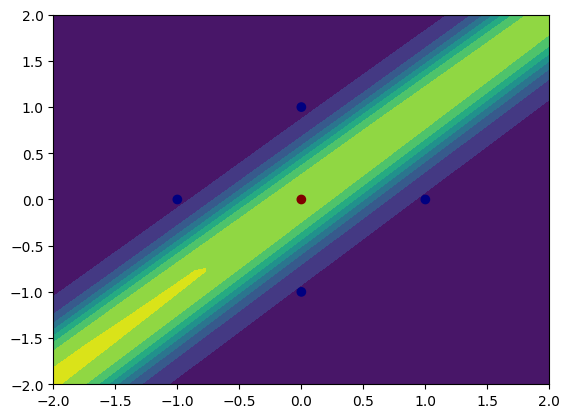

In [211]:
grid_range = torch.linspace(-2, 2, 50)
grid_x, grid_y = torch.meshgrid(grid_range, grid_range, indexing='ij')
grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
pred = predict(grid_data, *best_params)

plot_decision_boundary(x, y, grid_x, grid_y, pred)

Also try to visualize the decision boundary of network with random parameters:

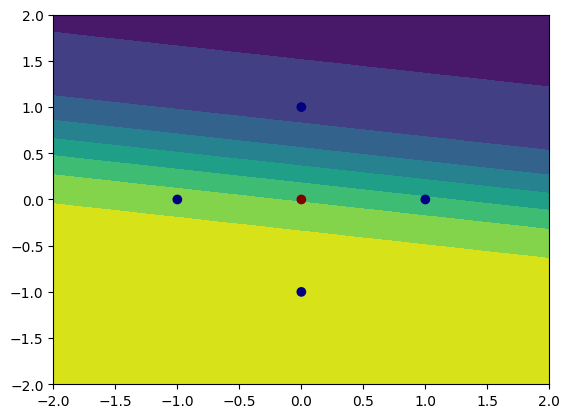

In [131]:
pred = predict(grid_data, *torch.randn(9))
plot_decision_boundary(x, y, grid_x, grid_y, pred)